In [11]:
from pyspark.sql.functions import *

In [12]:
flights_df = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load("flights.csv")

In [13]:
airlines_df = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load("airlines.csv")

In [14]:
flights_df.show(5)

+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+
|      date|airlines|flight_number|origin|destination|departure|departure_delay|arrival|arrival_delay|air_time|distance|
+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+
|2021-04-01|   19805|            1|   JFK|        LAX|      854|             -6|   1217|            2|     355|    2475|
|2021-04-01|   19805|            2|   LAX|        JFK|      944|             14|   1736|          -29|     269|    2475|
|2021-04-01|   19805|            3|   JFK|        LAX|     1224|             -6|   1614|           39|     371|    2475|
|2021-04-01|   19805|            4|   LAX|        JFK|     1240|             25|   2028|          -27|     264|    2475|
|2021-04-01|   19805|            5|   DFW|        HNL|     1300|             -5|   1650|           15|     510|    3784|
+----------+--------+-----------

In [15]:
airlines_df.show(5)

+-----+--------------------+
| Code|         Description|
+-----+--------------------+
|19031|Mackey Internatio...|
|19032|Munz Northern Air...|
|19033|Cochise Airlines ...|
|19034|Golden Gate Airli...|
|19035|  Aeromech Inc.: RZZ|
+-----+--------------------+
only showing top 5 rows



In [16]:
flightDetails_df = flights_df.drop('date', 'flight_number', 'origin', 'departure', 'arrival')

In [17]:
flightDetails_df.show(5)

+--------+-----------+---------------+-------------+--------+--------+
|airlines|destination|departure_delay|arrival_delay|air_time|distance|
+--------+-----------+---------------+-------------+--------+--------+
|   19805|        LAX|             -6|            2|     355|    2475|
|   19805|        JFK|             14|          -29|     269|    2475|
|   19805|        LAX|             -6|           39|     371|    2475|
|   19805|        JFK|             25|          -27|     264|    2475|
|   19805|        HNL|             -5|           15|     510|    3784|
+--------+-----------+---------------+-------------+--------+--------+
only showing top 5 rows



In [18]:
flightDetails_df.count()

476881

In [19]:
flightDetailsClean_df = flightDetails_df.dropna()

In [20]:
flightDetailsClean_df.count()

476881

In [41]:
flightStats_df = flightDetailsClean_df.join(airlines_df, flightDetailsClean_df.airlines == airlines_df.Code )

In [42]:
flightStats_filtered_df = flightStats_df.filter(flightStats_df.distance>2000).select('Code', 'Description', 'destination', 'departure_delay', 'arrival_delay', 'air_time', 'distance' )

In [45]:
flightStats_filtered_df.show(10)

+-----+--------------------+-----------+---------------+-------------+--------+--------+
| Code|         Description|destination|departure_delay|arrival_delay|air_time|distance|
+-----+--------------------+-----------+---------------+-------------+--------+--------+
|19805|American Airlines...|        LAX|             -6|            2|     355|    2475|
|19805|American Airlines...|        JFK|             14|          -29|     269|    2475|
|19805|American Airlines...|        LAX|             -6|           39|     371|    2475|
|19805|American Airlines...|        JFK|             25|          -27|     264|    2475|
|19805|American Airlines...|        HNL|             -5|           15|     510|    3784|
|19805|American Airlines...|        DFW|            126|           95|     385|    3711|
|19805|American Airlines...|        OGG|            125|          138|     497|    3711|
|19805|American Airlines...|        DFW|              4|          -22|     398|    3784|
|19805|American Airli

In [47]:
flightStats_combined_df = flightStats_filtered_df.withColumn('combined_delay_times', \
                                                             flightStats_filtered_df.departure_delay+\
                                                             flightStats_filtered_df.arrival_delay).\
                                                             drop('departure_delay', 'arrival_delay' )

In [61]:
flightStats_combined_df.show(10)

+-----+--------------------+-----------+--------+--------+--------------------+
| Code|         Description|destination|air_time|distance|combined_delay_times|
+-----+--------------------+-----------+--------+--------+--------------------+
|19805|American Airlines...|        LAX|     355|    2475|                -4.0|
|19805|American Airlines...|        JFK|     269|    2475|               -15.0|
|19805|American Airlines...|        LAX|     371|    2475|                33.0|
|19805|American Airlines...|        JFK|     264|    2475|                -2.0|
|19805|American Airlines...|        HNL|     510|    3784|                10.0|
|19805|American Airlines...|        DFW|     385|    3711|               221.0|
|19805|American Airlines...|        OGG|     497|    3711|               263.0|
|19805|American Airlines...|        DFW|     398|    3784|               -18.0|
|19805|American Airlines...|        LAX|     365|    2475|                12.0|
|19805|American Airlines...|        JFK|

In [62]:
flightStats_aggs = flightStats_combined_df.groupBy('Code', 'Description').\
                                                agg({"combined_delay_times": "avg", "air_time": "avg"})\
                                                .sort(col('avg(combined_delay_times)').desc())

In [63]:
flightStats_aggs = flightStats_aggs.withColumnRenamed("avg(combined_delay_times)", "AVG Combined Delay")\
                                    .withColumnRenamed("avg(air_time)", "AVG Airtime")

In [64]:
flightStats_aggs.show(10)

+-----+--------------------+------------------+------------------+
| Code|         Description|AVG Combined Delay|       AVG Airtime|
+-----+--------------------+------------------+------------------+
|19393|Southwest Airline...|25.467961165048543|275.43592233009707|
|20437|AirTran Airways C...|              18.8|266.44166666666666|
|21171|  Virgin America: VX|12.585792896448224|  312.847923961981|
|20409| JetBlue Airways: B6|12.003034243606415| 310.2847854356307|
|19790|Delta Air Lines I...|10.698739977090492|  291.994959908362|
|19805|American Airlines...| 8.135942872256017|308.61306532663315|
|19977|United Air Lines ...| 7.582413300428627| 309.2208078971295|
|19690|Hawaiian Airlines...| 5.757637474541752| 324.5234215885947|
|20355| US Airways Inc.: US| 3.625358577165806| 287.9974182444062|
|19930|Alaska Airlines I...|-3.710103092783505| 312.5913402061856|
+-----+--------------------+------------------+------------------+



In [65]:
flightStats_aggs_asPD = flightStats_aggs.toPandas()

<AxesSubplot:xlabel='Description'>

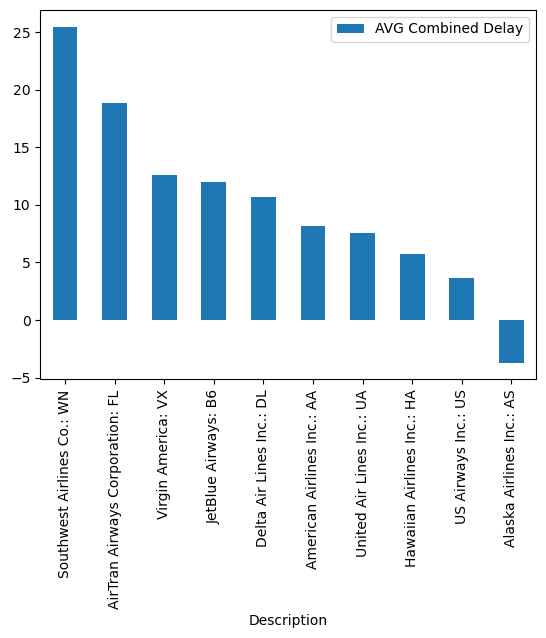

In [78]:
flightStats_aggs_asPD.plot(kind="bar", x="Description", y=["AVG Combined Delay"])